# Notebook to create simulated atmospheric transparencies 

Here we are going to create simulated atmospheric transparencies for different values of atmospheric parameters, such as precipitable water vapor (PWV), aerosols or different airmasses 

This notebook requires [libRadtran](http://www.libradtran.org/doku.php) 

# Load necessary packages 

In [1]:
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d as plt3d
import numpy as np
import os, sys
import matplotlib as mpl
import pandas as pd
import itertools
from astropy.io import fits
from scipy.stats import rayleigh,beta,gamma,uniform

In [2]:
output_dir = './simulated_transparencies/linear_distribution/discrete/'
if os.path.exists(output_dir) == False:
    os.mkdir(output_dir)

# Define function to generate simulated atm params according to their probability distributions 

In [3]:
def simul_params(n,min,max):
    
    sim_param = np.random.uniform(low=min,high=max,size=n)
        
    return sim_param

# Set parameters for simulation 

In [4]:
#Number of simulated parameters of each type 
nsim = 10000 #Note this number is used only here 
atm_params = ['pwv','aerosol','ozone','cloud','airmass']
################ airmass and clouds parameter values when fixing them 
fixed_cloud = 0.0
fixed_airmass = 1.2
################
dist_params = {'pwv':{'min':1.,'max':9.,'fixed':3.0},
               'aerosol':{'min':0.01,'max':0.09,'fixed':0.04},
               'ozone':{'min':200.,'max':400.,'fixed':300},
               'cloud':{'min':0.0,'max':1.0,'fixed':fixed_cloud},
               'airmass':{'min':1.0,'max':2.0,'fixed':fixed_airmass},
}

index_params = {'pwv':0,'aerosol':1,'ozone':2,'cloud':3,'airmass':4}
nparams = len(atm_params)

# Simulate some atmospheric parameters 

This is just a test for future simulations with random values following a given distribution. Note that the mean of the following uniform distributions is not necessarily the fixed value given in dist_params 

In [5]:
sim_dict = {}
for p in atm_params:
    min_ = dist_params[p]['min']
    max_ = dist_params[p]['max']
    param = simul_params(nsim,min_,max_)
    sim_dict[p] = param
    

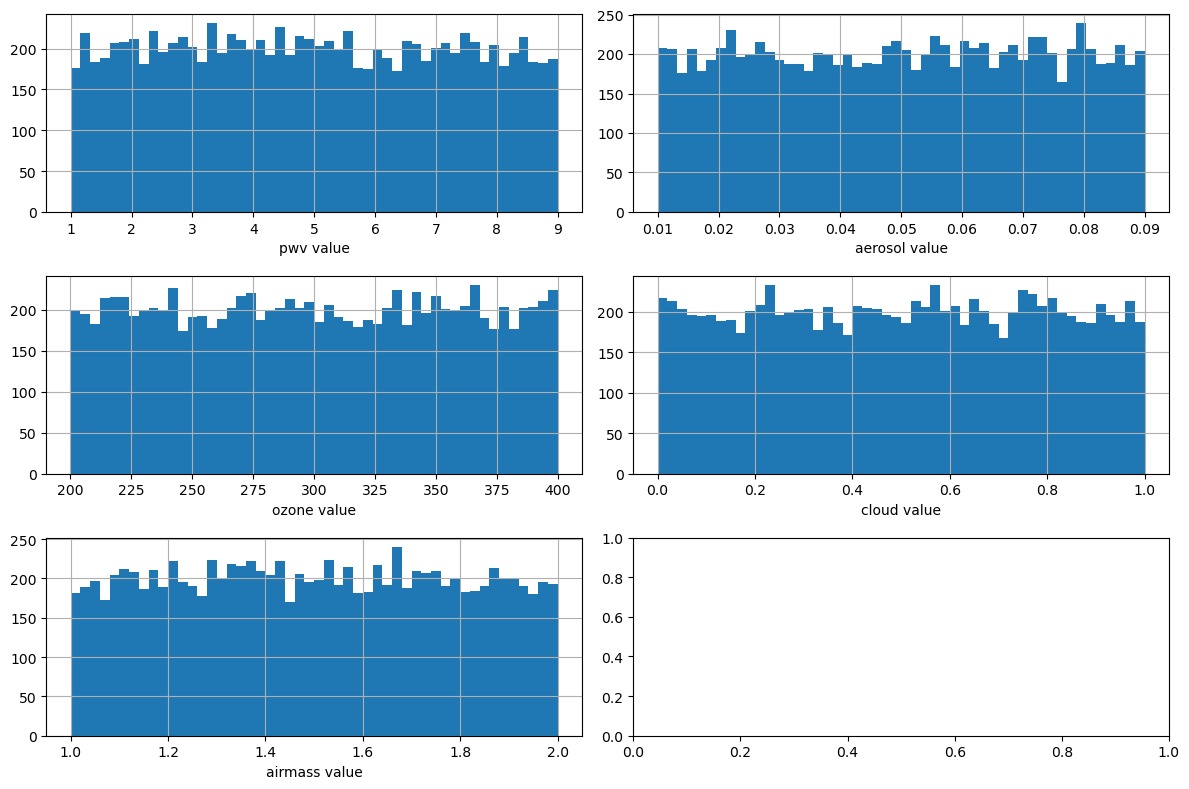

In [6]:
fig_rows = 3
fig_cols = 2
fig, axs = plt.subplots(fig_rows, fig_cols, figsize=(12,8))
i = 0
for row in range(fig_rows):
    for col in range(fig_cols):
        if i<len(atm_params):
            atm_param_ = atm_params[i]
            i += 1
            
            axs[row,col].hist(sim_dict[atm_param_],bins=50)
            axs[row,col].set_xlabel('{0} value'.format(atm_param_))
            axs[row,col].grid()
        
plt.tight_layout()

# Test fixing the parameters 

In [7]:
aer0 = dist_params['aerosol']['fixed']
oz0 = dist_params['ozone']['fixed']
pwv0 = dist_params['pwv']['fixed']
am0 = dist_params['airmass']['fixed']
cloud0 = dist_params['cloud']['fixed']
pressure = 0.0

print('Aerosols - PWV - Ozone - Clouds - Airmass - Pressure')
print(aer0,'-',pwv0,'-',oz0,'-',cloud0,'-',am0,'-',pressure)

Aerosols - PWV - Ozone - Clouds - Airmass - Pressure
0.04 - 3.0 - 300 - 0.0 - 1.2 - 0.0


Simulate an atm transparency from the fixed values 

In [8]:
sys.path.append('libradtran')
print(sys.path)

['/home/martin/auxtel_lsst/github/my_photomCorrectAuxtel/rubin-lsst_desc-pc_photometric_corrections_tutorial', '/home/martin/anaconda3/envs/rubin/lib/python310.zip', '/home/martin/anaconda3/envs/rubin/lib/python3.10', '/home/martin/anaconda3/envs/rubin/lib/python3.10/lib-dynload', '', '/home/martin/anaconda3/envs/rubin/lib/python3.10/site-packages', '__editable__.rubin_sim-0.13.1.finder.__path_hook__', 'libradtran']


This code was created by Sylvie Dagoret-Campagne to use libRadtran functionalities within python. This dependency will be updated soon in order to make this more user-friendly and to better integrate it within DESC infrastructure. 

In [9]:
import libsimulateVisible

libradtranpath= /home/martin/auxtel_lsst/External/libRadtran/


In [10]:
#Example with one PWV value, to see that everything works 
path,thefile=libsimulateVisible.ProcessSimulationaer(am0,pwv0,oz0,aer0,pressure,prof_str='us',proc_str='as',cloudext=cloud0)

Text(0.5, 1.0, 'PWV = 3.0, aerosol = 0.04, ozone = 300, airmass = 1.2, clouds = 0.0, pressure = 0.0')

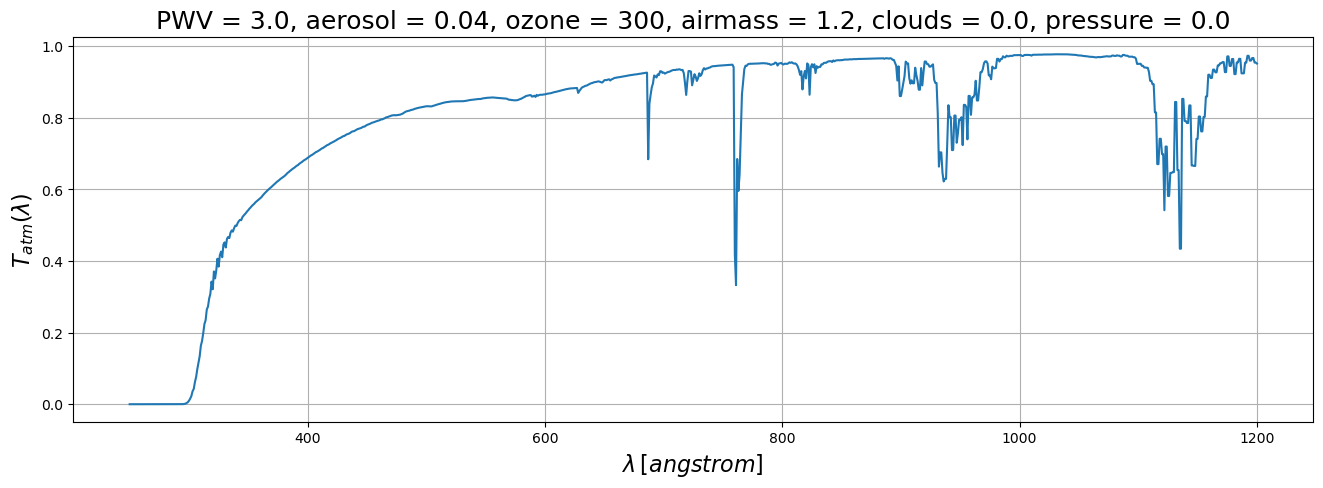

In [11]:
plt.figure(figsize=(16,5))

transp0 = np.loadtxt(os.path.join(path,thefile))
l = transp0[:,0]
t = transp0[:,1]

plt.plot(l,t)
plt.grid()
plt.xlabel(r'$\lambda \, [angstrom]$',fontsize=16)
plt.ylabel(r'$T_{atm}(\lambda)$',fontsize=16)
plt.title('PWV = {0}, aerosol = {1}, ozone = {2}, airmass = {3}, clouds = {4}, pressure = {5}'.format(pwv0,aer0,oz0,am0,cloud0,pressure),fontsize=18)

In [12]:
nwl = len(l)

# Check that the wavelenghts are the same 

In [13]:
path2,thefile2=libsimulateVisible.ProcessSimulationaer(am0,pwv0,oz0,aer0,pressure,prof_str='us',proc_str='as',cloudext=0)
transp02 = np.loadtxt(os.path.join(path2,thefile2))
wl = transp02[:,0]
print((wl==l).all())
wl_ref = wl

True


# Simulate atm transparencies for linearly spaced values of the selected parameter (we will vary only one parameter) 

Select variable atmospheric parameter and fix the others: 

In [14]:
variable_param = 'pwv'

In [15]:
fixed_params = {}
for param in atm_params:
    if param!=variable_param:
        fixed_params[param] = dist_params[param]['fixed']
        

In [16]:
fixed_params

{'aerosol': 0.04, 'ozone': 300, 'cloud': 0.0, 'airmass': 1.2}

In [17]:
if variable_param=='pwv':
    n_transp = 9
elif variable_param=='aerosol':
    n_transp = 9
print('Number of simulations = ', n_transp)

Number of simulations =  9


In [18]:
var_param = np.linspace(dist_params[variable_param]['min'],dist_params[variable_param]['max'],n_transp)

In [19]:
var_param

array([1., 2., 3., 4., 5., 6., 7., 8., 9.])

Create the simulations with libRadtran: 

In [20]:
dataout = np.zeros((n_transp+1,nwl+nparams))
dataout[0,nparams:] = wl_ref
for isim in range(1,n_transp+1):
    print(isim)
    for param in atm_params:
        if param != variable_param:
            dataout[isim,index_params[param]] = fixed_params[param]
        else:
            #dataout[isim,index_params[param]] = sim_dict[param][isim]
            dataout[isim,index_params[param]] = var_param[isim-1]
            
    airmass_ = dataout[isim,index_params['airmass']]
    pwv_ = dataout[isim,index_params['pwv']]
    ozone_ = dataout[isim,index_params['ozone']]
    aerosol_ = dataout[isim,index_params['aerosol']]
    cloud_ = dataout[isim,index_params['cloud']]
    #Run libradtran 
    path,thefile=libsimulateVisible.ProcessSimulationaer(airmass_,pwv_,ozone_,aerosol_,pressure,prof_str='us',proc_str='as',cloudext=cloud_)
    transp_file = np.loadtxt(os.path.join(path,thefile))
    
    t = transp_file[:,1]
    dataout[isim,nparams:] = t
    
# Reference atmosphere 
dataout_ref = np.zeros((2,nwl+nparams))
dataout_ref[0,nparams:] = wl_ref
for param in atm_params:
    if param!=variable_param:
        dataout_ref[1,index_params[param]] = fixed_params[param]
    else:
        if param=='airmass':
            dataout_ref[1,index_params[param]] = am0
        elif param=='cloud':
            dataout_ref[1,index_params[param]] = cloud0
        else:
            dataout_ref[1,index_params[param]] = dist_params[param]['fixed']
    
airmass_ = dataout_ref[1,index_params['airmass']]
pwv_ = dataout_ref[1,index_params['pwv']]
ozone_ = dataout_ref[1,index_params['ozone']]
aerosol_ = dataout_ref[1,index_params['aerosol']]
cloud_ = dataout_ref[1,index_params['cloud']]

path_ref,thefile_ref = libsimulateVisible.ProcessSimulationaer(airmass_,pwv_,ozone_,aerosol_,pressure,prof_str='us',proc_str='as',cloudext=cloud_)
transp_file_ref = np.loadtxt(os.path.join(path_ref,thefile_ref))

t_ref = transp_file_ref[:,1]
dataout_ref[1,nparams:] = t_ref

1
2
3
4
5
6
7
8
9


Save the simulated atmospheric transparencies: 

In [21]:
hdr = fits.Header()
hdr['NTRANSP']=n_transp
#hdr['ID_NUM']=idx_out_num
hdr['ID_AM']=index_params['airmass']
hdr['ID_VAOD']=index_params['aerosol']
hdr['ID_PWV']=index_params['pwv']
hdr['ID_O3']=index_params['ozone']
hdr['ID_CLD']=index_params['cloud']
hdr['ID_RES']=nparams

if variable_param=='airmass' or variable_param=='cloud':
    output_file = 'simulated_transparencies_varying_{0}.fits'.format(variable_param)
else:
    output_file = 'simulated_transparencies_varying_{0}_airmass_{1}_cloud_{2}.fits'.format(variable_param,am0,cloud0)

output_fullfilename = os.path.join(output_dir,output_file)

hdu = fits.PrimaryHDU(dataout,header=hdr)
hdu.writeto(output_fullfilename,overwrite=True)

Save the transparency of the reference / standard atmosphere: 

In [22]:
hdr = fits.Header()
hdr['NTRANSP']=n_transp
#hdr['ID_NUM']=idx_out_num
hdr['ID_AM']=index_params['airmass']
hdr['ID_VAOD']=index_params['aerosol']
hdr['ID_PWV']=index_params['pwv']
hdr['ID_O3']=index_params['ozone']
hdr['ID_CLD']=index_params['cloud']
hdr['ID_RES']=nparams

if variable_param=='airmass' or variable_param=='cloud':
    output_file = 'simulated_transparencies_varying_{0}_ref.fits'.format(variable_param)
else:
    output_file = 'simulated_transparencies_varying_{0}_airmass_{1}_cloud_{2}_ref.fits'.format(variable_param,am0,cloud0)

output_fullfilename_ref = os.path.join(output_dir,output_file)

hdu = fits.PrimaryHDU(dataout_ref,header=hdr)
hdu.writeto(output_fullfilename_ref,overwrite=True)